In [20]:
import pandas as pd
import numpy as np
import os
import glob
import ast 

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
os.chdir('/Users/user/Desktop/ВКР/Archive_movie')

In [7]:
names = glob.glob('*')
names

['links_small.csv',
 'links.csv',
 'credits.csv',
 'movies_metadata.csv',
 'ratings.csv',
 'ratings_small.csv',
 'keywords.csv',
 'catboost_info']

# Data understanding and processing

In [165]:
metadata = pd.read_csv('movies_metadata.csv')
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/266220343.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('movies_metadata.csv')


In [166]:
metadata.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

In [167]:
metadata.describe()

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


Add information about casts and directors to the metadata about the movie. Also add keywords.

In [168]:
credits_df=pd.read_csv('credits.csv')
keywords=pd.read_csv('keywords.csv')

In [169]:
i=metadata['id'][metadata['id'].str.contains('-')].index
metadata.drop(i,inplace=True)
metadata['id']=metadata['id'].astype('int')
metadata=metadata.merge(credits_df,on='id')
metadata=metadata.merge(keywords,on='id')
metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords'],
      dtype='object')

Processing columns

In [170]:
metadata['belongs_to_collection'] = metadata['belongs_to_collection'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [171]:
metadata['homepage'] = metadata['homepage'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [173]:
metadata['adult'] = metadata['adult'].apply(lambda x: 1 if eval(x) else 0)

In [175]:
metadata['overview_tagline_join'] = (metadata['overview'].apply(lambda x: '' if pd.isnull(x) else x) + \
                                    metadata['tagline'].apply(lambda x: '' if pd.isnull(x) else x)).apply(lambda x: None if x=='' else x)

In [176]:
metadata = metadata.drop(['overview', 'tagline'], axis = 1)

In [177]:
metadata = metadata.drop(['poster_path'], axis = 1)

In [178]:
metadata.dropna(inplace = True)

In [179]:
def convert(obj): 
    l=[] 
    for i in ast.literal_eval(obj): 
        l.append(i['name']) 
    return l

In [180]:
metadata['genres']=metadata['genres'].apply(convert)
metadata['keywords']=metadata['keywords'].apply(convert)

In [181]:
metadata['production_companies'] = metadata['production_companies'].apply(convert)
metadata['production_countries'] = metadata['production_countries'].apply(convert)

In [182]:
metadata['spoken_languages'] = metadata['spoken_languages'].apply(convert)

In [183]:
def convert(obj):
    l=[] 
    counter=0 
    for i in ast.literal_eval(obj): 
        if counter !=3 : 
            l.append(i['name']) 
            counter+=1 
        else: 
            break 
    return l

In [184]:
metadata['cast']=metadata['cast'].apply(convert)

In [185]:
def fetch_director(obj):
    l=[]
    for i in ast.literal_eval(obj):
        if i['job']=='Director':
            l.append(i['name'])
    return l

In [186]:
metadata['crew']=metadata['crew'].apply(fetch_director)

In [187]:
float_columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
for col in float_columns:
    metadata[col] = metadata[col].astype(float)

In [188]:
from itertools import chain

temp = pd.DataFrame({
    'genres' : list(chain.from_iterable(metadata.genres.tolist())), 
    'revenue' : metadata.revenue.repeat(metadata.genres.str.len())
})

<BarContainer object of 20 artists>

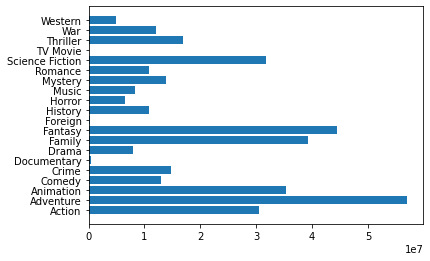

In [189]:
genres_revenue = dict(temp.groupby('genres').revenue.mean())
plt.barh(list(genres_revenue.keys()), genres_revenue.values())

Adventures earn the most, and documentary earn the least. 

In [190]:
temp = pd.DataFrame({
    'production countries' : list(chain.from_iterable(metadata['production_countries'].tolist())), 
    'revenue' : metadata.revenue.repeat(metadata['production_countries'].str.len())
})

Top 15 countries by movie revenue

<BarContainer object of 15 artists>

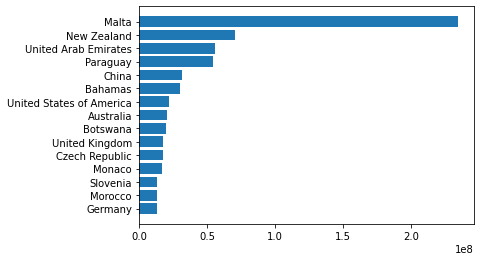

In [191]:
countries_revenue = dict(temp.groupby('production countries').revenue.mean())
countries_revenue_max = {k: countries_revenue[k] for k in sorted(countries_revenue, key=countries_revenue.get)[-15:]}
plt.barh(list(countries_revenue_max.keys()), countries_revenue_max.values())

Top 15 countries by movie budget

<BarContainer object of 15 artists>

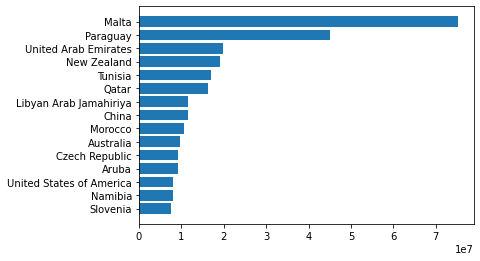

In [192]:
temp = pd.DataFrame({
    'production countries' : list(chain.from_iterable(metadata['production_countries'].tolist())), 
    'budget' : metadata.budget.repeat(metadata['production_countries'].str.len())
})

countries_budget = dict(temp.groupby('production countries').budget.mean())
countries_budget_max = {k: countries_budget[k] for k in sorted(countries_budget, key=countries_budget.get)[-15:]}
plt.barh(list(countries_budget_max.keys()), countries_budget_max.values())

<AxesSubplot:>

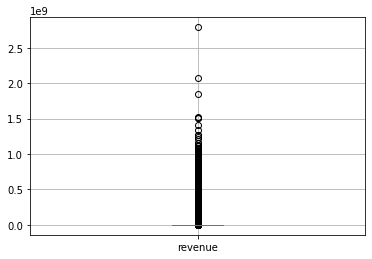

In [193]:
metadata.boxplot(column = 'revenue')

In [194]:
metadata[metadata['revenue'] > 0]['id'].count()

7513

Since only films that were released in cinemas are considered, those items in which the profit value is zero should be removed

In [195]:
metadata = metadata[metadata['revenue'] > 0]

In [196]:
metadata.revenue.describe()

count    7.513000e+03
mean     6.842426e+07
std      1.460801e+08
min      1.000000e+00
25%      2.346150e+06
50%      1.675716e+07
75%      6.682104e+07
max      2.787965e+09
Name: revenue, dtype: float64

<AxesSubplot:>

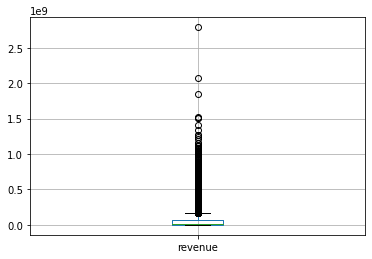

In [197]:
metadata.boxplot(column = 'revenue')

In [198]:
metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords',
       'overview_tagline_join'],
      dtype='object')

<AxesSubplot:>

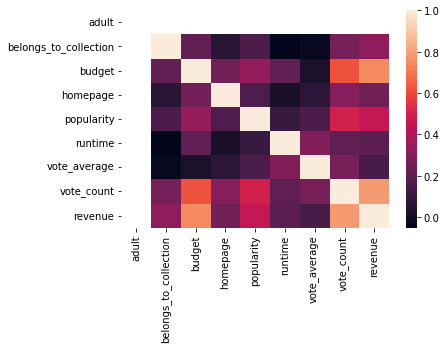

In [199]:
sns.heatmap(metadata[['adult', 'belongs_to_collection', 'budget','homepage', 'popularity', 'runtime', 'vote_average', 'vote_count','revenue']].corr())

The film's budget is the biggest influence on the box office, the number of votes is also important (for unreleased films, this can be the number of votes waiting for the film). Other factors that play a role are the possession of the film in the collection and the popularity of the film. However, the popularity of the film is not known before its release, so it is of no interest to us.

Genres and countries of production, as well as production companies, can be converted into categorical features. Let's encode them:

In [200]:
from sklearn.preprocessing import MultiLabelBinarizer

In [201]:
mlb = MultiLabelBinarizer()
res = mlb.fit_transform(metadata['genres'])
for i in range(len(mlb.classes_)):
    metadata[mlb.classes_[i]] = res.T[i]

In [202]:
mlb = MultiLabelBinarizer()
res = mlb.fit_transform(metadata['genres'])
for i in range(len(mlb.classes_)):
    metadata[mlb.classes_[i]] = res.T[i]

For each country, we calculate its occurrence in the data set and replace rarely occurring countries with "other"

In [129]:
from collections import Counter
count_countries = Counter([item for lst in metadata['production_countries'] for item in lst])

In [140]:
count_countries.values()

dict_values([5681, 922, 609, 418, 170, 135, 150, 24, 324, 173, 96, 43, 129, 72, 1, 20, 26, 11, 37, 45, 4, 1, 62, 233, 18, 30, 24, 17, 41, 8, 58, 17, 30, 23, 103, 6, 1, 23, 2, 26, 3, 4, 1, 5, 16, 3, 1, 3, 13, 1, 7, 3, 61, 3, 9, 6, 5, 3, 10, 1, 13, 1, 1, 11, 1, 1, 1, 10, 8, 8, 3, 1, 1, 1, 1, 16, 2, 1, 1, 2, 1, 5, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 4, 1, 1])

In [160]:
other = [k for k in count_countries.keys() if count_countries[k] <= 5]
metadata['production_countries'] = metadata['production_countries'].apply(lambda x: list({i if i not in other else "other" for i in x}))
metadata['production_countries'] = metadata['production_countries'].apply(lambda x: ['other'] if not x else x)

0        [United States of America]
1        [United States of America]
3        [United States of America]
4        [United States of America]
5        [United States of America]
                    ...            
46543                      [Russia]
46563                      [Russia]
46571                       [other]
46574                      [Russia]
46584                      [Russia]
Name: production_countries, Length: 7513, dtype: object

In [203]:
mlb = MultiLabelBinarizer()
res = mlb.fit_transform(metadata['production_countries'])
for i in range(len(mlb.classes_)):
    metadata[mlb.classes_[i]] = res.T[i]

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/2942120319.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/2942120319.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/2942120319.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

Do the same with companies

In [204]:
from collections import Counter
count_companies = Counter([item for lst in metadata['production_companies'] for item in lst])
count_companies.values()

dict_values([18, 121, 2, 19, 343, 4, 158, 81, 9, 491, 464, 1, 5, 105, 22, 238, 44, 68, 3, 54, 12, 3, 8, 208, 22, 2, 1, 1, 141, 18, 112, 7, 1, 40, 16, 42, 138, 20, 6, 1, 1, 199, 7, 1, 17, 2, 15, 4, 1, 12, 6, 1, 23, 2, 28, 3, 2, 2, 1, 1, 1, 1, 3, 8, 16, 1, 10, 1, 36, 64, 16, 1, 1, 3, 4, 3, 2, 149, 11, 1, 12, 7, 409, 3, 1, 60, 3, 2, 2, 2, 1, 1, 1, 5, 9, 38, 2, 2, 3, 10, 1, 15, 31, 3, 6, 15, 13, 1, 1, 1, 16, 7, 18, 5, 10, 2, 48, 3, 8, 1, 1, 16, 14, 1, 2, 1, 1, 2, 1, 1, 6, 13, 8, 2, 4, 1, 1, 1, 17, 1, 9, 2, 7, 1, 1, 3, 1, 1, 3, 7, 37, 2, 4, 1, 1, 2, 1, 10, 46, 2, 20, 11, 2, 3, 13, 3, 2, 13, 6, 1, 14, 4, 8, 6, 22, 1, 1, 5, 1, 10, 2, 4, 1, 1, 1, 8, 5, 3, 26, 4, 2, 2, 56, 2, 11, 3, 12, 66, 2, 1, 4, 21, 3, 2, 1, 3, 4, 2, 6, 4, 2, 11, 1, 1, 1, 8, 1, 2, 21, 4, 1, 1, 11, 11, 3, 1, 1, 13, 12, 4, 8, 6, 8, 4, 1, 5, 4, 1, 1, 1, 1, 56, 40, 4, 1, 1, 1, 5, 1, 1, 1, 8, 2, 4, 1, 1, 1, 1, 2, 13, 1, 17, 14, 1, 2, 3, 4, 2, 1, 2, 8, 15, 1, 5, 1, 6, 4, 1, 3, 8, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 8, 11, 16, 1, 16,

In [205]:
other = [k for k in count_companies.keys() if count_companies[k] <= 5]
metadata['production_companies'] = metadata['production_companies'].apply(lambda x: list({i if i not in other else "other" for i in x}))
metadata['production_companies'] = metadata['production_companies'].apply(lambda x: ['other'] if not x else x)

In [206]:
mlb = MultiLabelBinarizer()
res = mlb.fit_transform(metadata['production_companies'])
for i in range(len(mlb.classes_)):
    metadata[mlb.classes_[i]] = res.T[i]

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metadata[mlb.classes_[i]] = res.T[i]
/var/folders/d7/b6t8w9c960vb7cps3hrj9q_h0000gn/T/ipykernel_34729/3856767485.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

Сasts and directors cannot be considered categorical factors, since the number of unique values is too large, and the probability of new values appearing is high.

Let's create another column: the average ratings of films in which the actors participated

In [207]:
actors = list({i for lst in metadata['cast'] for i in lst})
actors_ranking = {}
for a in actors:
    rank = metadata[metadata['cast'].apply(lambda x: a in x)]['vote_average'].mean()
    actors_ranking[a] = rank

In [208]:
metadata['cast_ranking'] = metadata['cast'].apply(lambda x: np.mean(np.array([actors_ranking[a] for a in x])))

/Users/user/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


Do the same with directors

In [209]:
crew = list({i for lst in metadata['crew'] for i in lst})
crew_ranking = {}
for a in crew:
    rank = metadata[metadata['crew'].apply(lambda x: a in x)]['vote_average'].mean()
    crew_ranking[a] = rank

metadata['crew_ranking'] = metadata['crew'].apply(lambda x: np.mean(np.array([crew_ranking[a] for a in x])))

/Users/user/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


<AxesSubplot:>

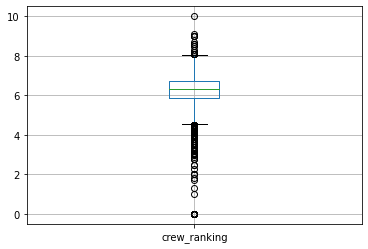

In [210]:
metadata.boxplot(column = 'crew_ranking')

<AxesSubplot:>

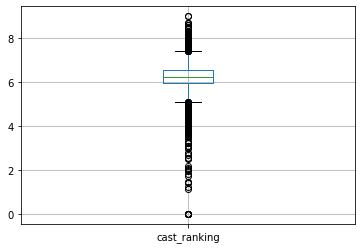

In [211]:
metadata.boxplot(column = 'cast_ranking')

It is planned to use gradient boosting to build the model, so the data normalization is not needed

In [214]:
metadata.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'popularity',
       ...
       'XYZ Films', 'Yari Film Group', 'Yash Raj Films',
       'Zentropa Entertainments', 'Zide-Perry Productions',
       'Zweites Deutsches Fernsehen (ZDF)', 'other', 'uFilm', 'cast_ranking',
       'crew_ranking'],
      dtype='object', length=722)

In [215]:
metadata.to_csv('processed_IMDB_dataset.csv', index=False)